In [1]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import tensorflow as tf
from keras import backend as K
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import *

**Preprocessing**

In [2]:
base_dir = '/kaggle/input/pneumonia-xray-images'


print('Contents of base directory:')
print(os.listdir(base_dir))

print('\nContents of train directory:')
print(os.listdir(f'{base_dir}/train'))

print('\nContents of val directory:')
print(os.listdir(f'{base_dir}/val'))

print('\nContents of test directory:')
print(os.listdir(f'{base_dir}/test'))

Contents of base directory:
['val', 'test', 'train']

Contents of train directory:
['normal', 'opacity']

Contents of val directory:
['normal', 'opacity']

Contents of test directory:
['normal', 'opacity']


In [3]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

#Directory with training NORMAL/PNEUMONIA pictures
train_NORMAL_dir = os.path.join(train_dir, 'normal')
train_PNEUMONIA_dir = os.path.join(train_dir, 'opacity')

#Directory with validation NORMAL/PNEUMONIA pictures
val_NORMAL_dir = os.path.join(val_dir, 'normal')
val_PNEUMONIA_dir = os.path.join(val_dir, 'opacity')

#Directory with test NORMAL/PNEUMONIA pictures
test_NORMAL_dir = os.path.join(test_dir, 'normal')
test_PNEUMONIA_dir = os.path.join(test_dir, 'opacity')

In [4]:
train_NORMAL_fnames = os.listdir(train_NORMAL_dir)
train_PNEUMONIA_fnames = os.listdir(train_PNEUMONIA_dir)

print(train_NORMAL_fnames[:5])
print(train_PNEUMONIA_fnames[:5])

['NORMAL2-IM-0771-0001.jpeg', 'IM-0675-0001.jpeg', 'IM-0421-0001.jpeg', 'NORMAL2-IM-0531-0001.jpeg', 'NORMAL2-IM-0416-0001-0002.jpeg']
['person1180_virus_2010.jpeg', 'person1230_virus_2081.jpeg', 'person124_virus_238.jpeg', 'person746_virus_1369.jpeg', 'person588_bacteria_2422.jpeg']


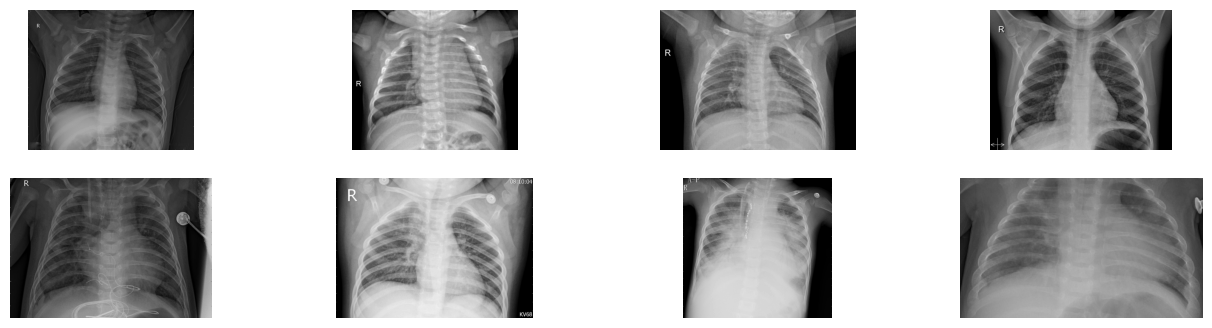

In [5]:
nrows = 2
ncols = 4

pic_index = 0 #Index for iterating over images

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*2)

pic_index+=4

next_NORMAL_pix = [os.path.join(train_NORMAL_dir, fname) 
                for fname in train_NORMAL_fnames[pic_index-4:pic_index]]

next_PNEUMONIA_pix = [os.path.join(train_PNEUMONIA_dir, fname) 
                for fname in train_PNEUMONIA_fnames[pic_index-4:pic_index]]

for i, img_path in enumerate(next_NORMAL_pix+next_PNEUMONIA_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img, cmap='gray')

plt.show();

**As we can see, by just observing we cannot tell the difference between the affected lungs and the normal ones. Let's see how well our model works to classify the x-rays.**

In [6]:
print('total training NORMAL images :', len(os.listdir(train_NORMAL_dir)))
print('total training PNEUMONIA images :', len(os.listdir(train_PNEUMONIA_dir)))

print('total validation NORMAL images :', len(os.listdir(val_NORMAL_dir)))
print('total validation PNEUMONIA images :', len(os.listdir(val_PNEUMONIA_dir)))

print('total test NORMAL images :', len(os.listdir(test_NORMAL_dir)))
print('total test PNEUMONIA images :', len(os.listdir(test_PNEUMONIA_dir)))

total training NORMAL images : 1082
total training PNEUMONIA images : 3110
total validation NORMAL images : 267
total validation PNEUMONIA images : 773
total test NORMAL images : 234
total test PNEUMONIA images : 390


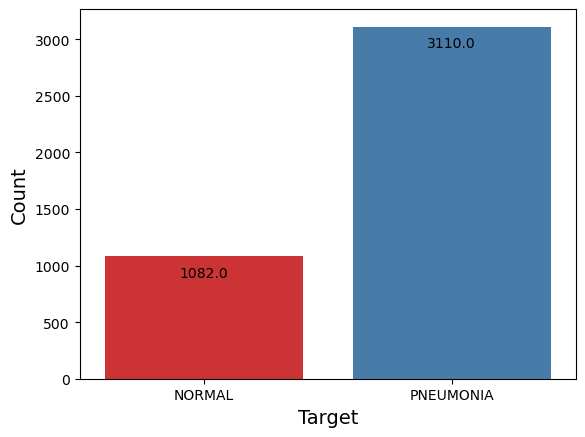

In [7]:

ax = sns.barplot(x = ['NORMAL', 'PNEUMONIA'], y = [len(os.listdir(train_NORMAL_dir)), len(os.listdir(train_PNEUMONIA_dir))]
            , palette = 'Set1')
for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -12), 
                   textcoords = 'offset points')
plt.xlabel('Target', size=14)
plt.ylabel('Count', size=14);

**Now, we can see that our datset is imbalanced. About 75% of the train data has PNEUMONIA label.**

For the data augmentation, we will have to:

* Randomly rotate some training images by 30 degrees
* Randomly Zoom by 20% some training images
* Randomly shift images horizontally by 10% of the width
* Randomly shift images vertically by 10% of the height
* Randomly flip images horizontally
* All images will be rescaled by 1/255 and also only one channel(Greyscale) images are used 

In [8]:
train_datagen = ImageDataGenerator(rescale = 1.0/255., 
                                   featurewise_center=False,  # set input mean to 0 over the dataset
                                   samplewise_center=False,  # set each sample mean to 0
                                   featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                   samplewise_std_normalization=False,  # divide each input by its std
                                   zca_whitening=False,  # apply ZCA whitening
                                   rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
                                   zoom_range = 0.2, # Randomly zoom image 
                                   width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                   height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                                   horizontal_flip = True,  # randomly flip images
                                   vertical_flip=False)
val_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

# --------------------
#Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 128,
                                                    class_mode = 'binary',
                                                    target_size = (299, 299),
                                                    color_mode='grayscale')     
# --------------------
#Flow validation images in batches of 20 using val_datagen generator
# --------------------
val_generator =  val_datagen.flow_from_directory(val_dir,
                                                 batch_size = 8,
                                                 class_mode = 'binary',
                                                 target_size = (299, 299),
                                                 color_mode='grayscale')
# --------------------
#Flow test images in batches of 20 using test_datagen generator
# --------------------
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                   batch_size = 64,
                                                   class_mode = 'binary',
                                                   target_size = (299, 299),
                                                   color_mode='grayscale')

Found 4192 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**MODEL 1: CNN**

In [9]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(299, 299, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 297, 297, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                        

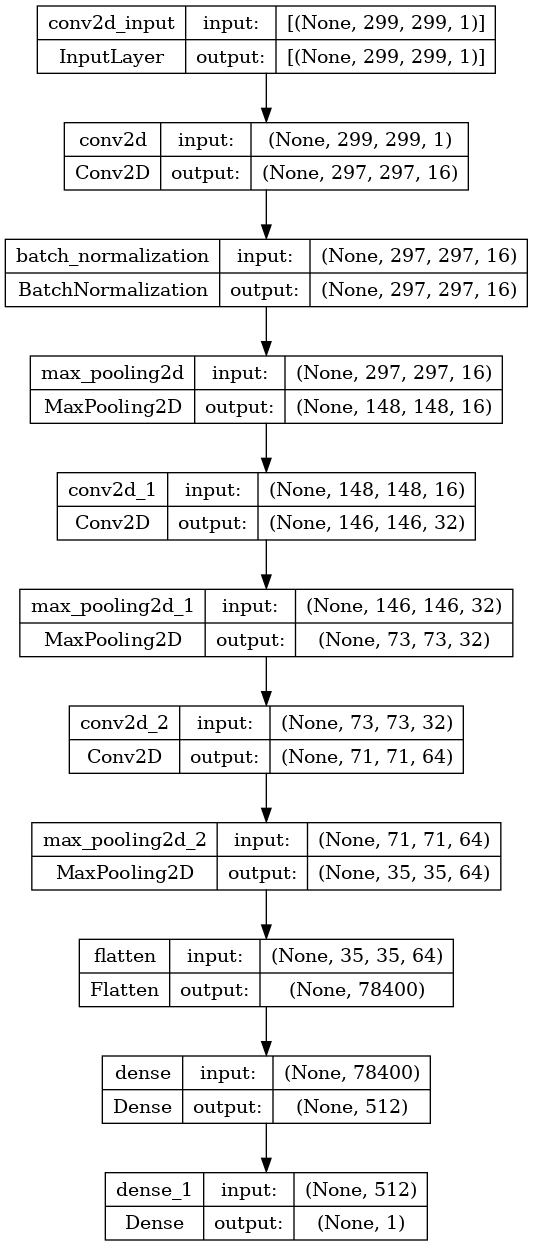

In [11]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [12]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision1 = precision(y_true, y_pred)
    recall1 = recall(y_true, y_pred)
    return 2*((precision1*recall1)/(precision1+recall1+K.epsilon()))

In [13]:
import tensorflow as tf
early_stopping=tf.keras.callbacks. EarlyStopping (
monitor="val_loss",
min_delta=0.01,
patience=5,
verbose=0,
mode="auto",
baseline=None,
restore_best_weights=False,
)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy', f1, precision, recall])

# Fit the model with early stopping
history = model.fit(train_generator,
                    epochs=8,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/8
33/33 [==============================] - 105s 3s/step - loss: 348.2664 - accuracy: 0.6875 - f1: 0.7247 - precision: 0.7312 - recall: 0.7687
Epoch 2/8
33/33 [==============================] - 53s 2s/step - loss: 1.0315 - accuracy: 0.7657 - f1: 0.8250 - precision: 0.8359 - recall: 0.8838
Epoch 3/8
33/33 [==============================] - 53s 2s/step - loss: 0.4837 - accuracy: 0.7779 - f1: 0.8381 - precision: 0.8440 - recall: 0.8933
Epoch 4/8
33/33 [==============================] - 53s 2s/step - loss: 0.7420 - accuracy: 0.7417 - f1: 0.8178 - precision: 0.7990 - recall: 0.9084
Epoch 5/8
33/33 [==============================] - 53s 2s/step - loss: 0.6297 - accuracy: 0.7171 - f1: 0.8205 - precision: 0.7463 - recall: 0.9622
Epoch 6/8
33/33 [==============================] - 54s 2s/step - loss: 0.5056 - accuracy: 0.7600 - f1: 0.8575 - precision: 0.7736 - recall: 0.9736
Epoch 7/8
33/33 [==============================] - 53s 2s/step - loss: 1.3466 - accuracy: 0.7834 - f1: 0.8656 - pre

In [14]:
model.evaluate(test_generator)

10/10 [==============================] - 10s 913ms/step - loss: 0.7843 - accuracy: 0.6250 - f1: 0.7663 - precision: 0.6234 - recall: 1.0000


[0.7842791676521301, 0.625, 0.7663154006004333, 0.6234375238418579, 1.0]

Recall is an important metric especially in healthcare data. Recall literally is how many of the true positives were found, i.e. how many of the correct hits were also found.
